# Kalman filter to mean-reversion model

### Let's see mean-reversion model.

This random process may be known as [Ornstein–Uhlenbeck process](https://en.m.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

Stochastic equation: $dX(t) = a( \overline{X} - X(t))dt + bdw(t)$, $X(0) = X_0$

Solution: $X(t) = X_0 \cdot e^{-at} + \overline{X} (1 - e^{-at}) + b\int_0^t e^{-a(t-s)}dw(s) $

Expected: $EX(t) = X_0 \cdot e^{-at} + \overline{X} (1 - e^{-at})$

Kovariation: $cov(X_t, X_s) = \frac{b^2}{2a} (e^{-a|t-s|} - e^{a(t+s)}) $

$D X(t) = cov(X_t, X_t)= \frac{b^2}{2a} (1 - e^{-2at})$





### Simulation
We can simulate this random process by Euler–Maruyama method

So we will have formula

$X_t = X_{t-1} + a(\bar{X} - X_{t-1}) + b \sqrt{h} V,\\ V \sim N(0,1)$

<br>

### Observe

Imagine, we can observe values of one of realizations of this process $Y$

And $Y_t = X_t + B \sqrt{H} W, \\ W \sim N(0,1)$

<br>
So, we have equation for observed values and for realization

$\begin{equation*}
 \begin{cases}
   X_t = X_{t-1} + a(\bar{X} - X_{t-1}) h + b \sqrt{h} V, t \in N\\
   Y_t = X_t + B \sqrt{H} W \\
   Y_0 = X_0 + B \sqrt{H} W
 \end{cases}
\end{equation*}$

<br>

### Use Kalman filter

Now we can rewrite this system to terms of Kalman filter

$\begin{equation*}
 \begin{cases}
   X_t = (1 - a h)X_{t-1} + a \bar{X} h  + b \sqrt{h} V, t \in N\\
   Y_t = X_t + B \sqrt{H} W \\
   Y_0 = X_0 + B \sqrt{H} W
 \end{cases}
\end{equation*}$

<br> **Note**: we will observe $Y$ not in all times, so we will estimate $\hat{X}$ sometimes without correction

**Note**: you can see my interpretation and realization of Kalman filter in [Kalman filter.ipynb](https://github.com/pudovikoff/Random_Processes/blob/main/Kalman%20filter.ipynb)

**Note**: you can see more about mean-recersion model in [Stochactic Differential Equations.ipynb](https://github.com/pudovikoff/Random_Processes/blob/main/Stochactic%20Differential%20Equations.ipynb)

In [1]:
import math
import numpy as np 
import scipy.stats as ss
import scipy.integrate as integrate
import scipy.special as special
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
class Observing_Mean_Reversion:
    def __init__(self, a, b, x0, T, x_mean, H, B, h, p_w):
        '''
        a, b, x_mean, x0 - constants for mean-reversion
        T - [0, T] - interval for mean-reversion simulation
        h - step of mean-reversion simulation
        H - step of observing mean-reversion
        '''
        self.a, self.b, self.x0, self.x_mean, self.T = a, b, x0, x_mean, T
        self.h, self.H = h, H
        self.B = B
        self.time = [0]
        self.p_w = p_w
    
    
    def mean_reversion_simulation(self):
        '''
        making one simulation of mean_reversion process
        using Euler–Maruyama method
        a, b - fixes constants
        x0 - starting point at t=0
        x_mean - fixed mean value
        T - total time of simulation
        h - step for simulation    
        '''
        steps = int(self.T/self.h)
        mean_reversion = np.zeros(steps + 1)
        mean_reversion[0] = self.x0
        for i in range(1, steps + 1):
            prev = mean_reversion[i-1]
            mean_reversion[i] = prev + self.a * (self.x_mean - prev)* self.h + self.b * self.h ** 0.5 * np.random.normal(size=1)
            self.time.append(i * self.h)
        self.mean_rev = mean_reversion
        return mean_reversion
    
    
    def mean_reversion_mean(self):
        '''
        making mean value of mean_reversion process
        a, b - fixes constants
        x0 - starting point at t=0
        x_mean - fixed mean value
        T - total time of simulation
        h - step for simulation    
        '''
        steps = int(self.T/self.h)
        mean = np.zeros(steps + 1)
        mean[0] = self.x0
        for i,tau in enumerate(self.time):
            #tau = i * self.h
            mean[i] = self.x0 * np.exp(- self.a * tau) + self.x_mean * (1 - np.exp(- self.a * tau))
        return mean
    
    def observe(self):
        '''
        oberve our mean-reversion
        in suppose H = k * h
        k - some integer
        '''
        k = int(H/h)
        
        tmp = self.mean_rev[[i for i in range(0, len(self.mean_rev), k)]]
        y = tmp + self.B * H ** 0.5 * self.p_w.rvs(size = len(tmp))[0]
        
        self.observed = y
        self.k = k
        return y
    
    def estimate(self):
        '''
        kalman filter - read above for more comments
        '''
        self.est_x_list = []
        self.est_cov_list = []
        
        # translating our params to Kalman filter terms
        a = 1 - self.a * self.h
        c = self.a * self.x_mean * self.h
        b = self.b * h ** 0.5 
        A = 1
        C = 0
        B = self.B * H ** 0.5
        
        for i in tqdm(range(len(self.mean_rev))):
            if i == 0:
                # start
                X_hat = self.x0
                self.est_x_list.append(X_hat)
                
                k0 = 1
                self.est_cov_list.append(k0)
            else:
                #prediction
                
                X_wide = a * self.est_x_list[i - 1] + c
                k_wide = a * self.est_cov_list[i - 1] * a + b * b
                
                #correction if and only if we have observed value at this time
                if not i % self.k:
                    X_hat = X_wide + k_wide * A * (A * k_wide * A + B * B)**(-1) * (self.observed[int(i/self.k)] - A * X_wide - C)
                    k = k_wide - k_wide * A * (A * k_wide * A + B * B)**(-1) * A * k_wide
                else:
                    X_hat = X_wide
                    k = k_wide
                
                self.est_x_list.append(X_hat)
                self.est_cov_list.append(k)
        
        return self.est_x_list, self.est_cov_list
        
                

In [3]:
a, b, x0, T, x_mean = 1, 2, 1, 0.5, 5
k, m = 3, 1
c = 5
H = 0.01
B = 2
h = 0.001
p_w = ss.norm(loc = 0, scale = 1)

OMR = Observing_Mean_Reversion(a, b, x0, T, x_mean, H, B, h, p_w)
x = OMR.mean_reversion_simulation() 
y = OMR.observe()
x_est, cov_est = OMR.estimate()
x_expected = OMR.mean_reversion_mean()

  0%|          | 0/501 [00:00<?, ?it/s]

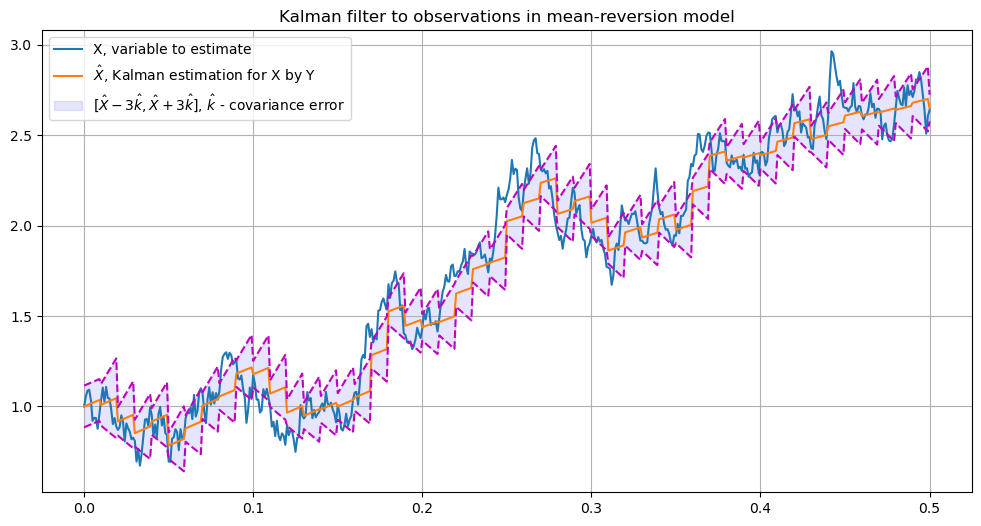

In [4]:
plt.figure(figsize=(12, 6))
plt.grid(True)

cov_est = np.array(cov_est)
cov_est[:10] = cov_est[10]
t = OMR.time
t_est = np.array([i for i in range(0, len(x)+1, int(H/h))][:]) * h

plt.plot(t, x, label='X, variable to estimate')
plt.plot(t, x_est, label="$\hat{X}$, Kalman estimation for X by Y")

plt.plot(t, np.array(x_est) + 3 * np.array(cov_est), linestyle='--', color='m')
plt.plot(t, np.array(x_est) - 3 * np.array(cov_est), linestyle='--', color='m')
plt.fill_between(t, np.array(x_est) + 3 * np.array(cov_est),
                 np.array(x_est) - 3 * np.array(cov_est), color='blue',
                 alpha= 0.1, label='[$\hat{X} - 3 \hat{k}, \hat{X} + 3 \hat{k}$], $\hat{k}$ - covariance error' ) 

plt.title("Kalman filter to observations in mean-reversion model")
plt.legend()

In [5]:
OMR = Observing_Mean_Reversion(a, b, x0, 1, x_mean, H, B, h, p_w)
x = OMR.mean_reversion_simulation() 
y = OMR.observe()
x_est, cov_est = OMR.estimate()
x_expected = OMR.mean_reversion_mean()

  0%|          | 0/1001 [00:00<?, ?it/s]

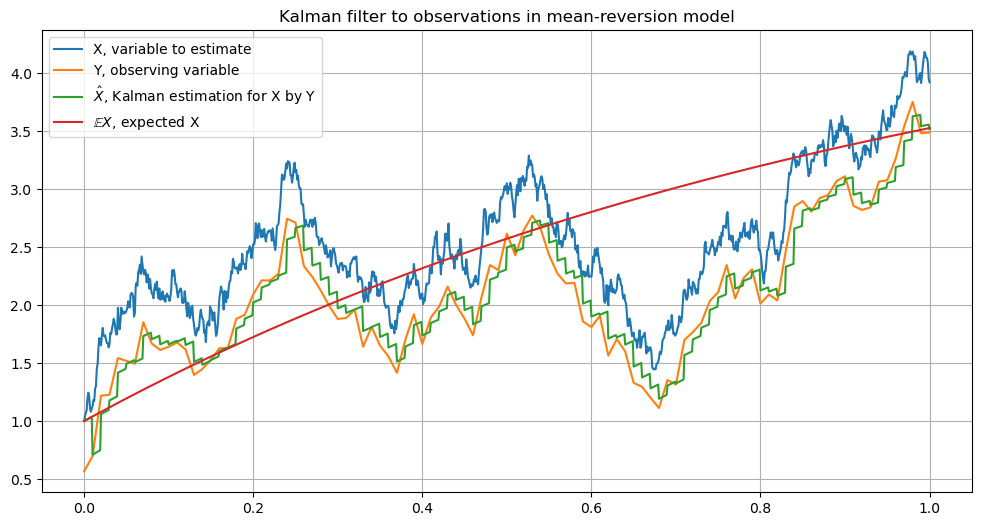

In [6]:
plt.figure(figsize=(12, 6))
plt.grid(True)

t = OMR.time
t_est = np.array([i for i in range(0, len(x)+1, int(H/h))][:]) * h
cov_est = np.array(cov_est)
cov_est[:10] = cov_est[10]

plt.plot(t, x, label='X, variable to estimate')
plt.plot(t_est, y, label='Y, observing variable')
plt.plot(t, x_est, label="$\hat{X}$, Kalman estimation for X by Y")
plt.plot(t, x_expected, label="$\mathbb{E}{X}$, expected X")

plt.title("Kalman filter to observations in mean-reversion model")
plt.legend()

Classic expected value is worst estimation for mean-reversion / Ornstein–Uhlenbeck process

Kalman filter is good enough

**Results**

It is easy to use Kalman filter to make estimations for some random processes. Here was used mean-reversion model.